In [1]:
#Google Colab
#!pip install torchinfo

#!unzip shuffled_dataset.zip -d dataset

#Import necessary modules
import torch
import seaborn as sns
import time
from PIL import Image as pil_image

import matplotlib.pyplot as plt
from os import path, listdir, walk
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import Conv2d, ReLU, MaxPool2d, Sequential, BatchNorm2d, Dropout2d, Sigmoid, LazyLinear, BCEWithLogitsLoss
from torch.optim import AdamW, SGD, Adagrad, Adam
from torchinfo import summary
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import random
import pandas as pd

#Google Colab. Change working directory to the dataset root
#%cd dataset

#Initialize variables and configuration
#Relative path for dataset for more robustness. Assumes it is a directory with three subdirectories.
DATASET_PATH = "shuffled_dataset"
IMAGE_SIZE = (256, 256)
#Batch size is 64 for Google Colab+ using A100 GPU. Otherwise needs to be set at 8 or lower for GPUs with 8GB VRAM.
BATCH_SIZE = 64

#Check Cuda
print("Cuda Check: {}".format(torch.cuda.is_available()))

#Check Torch version
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(3)

Cuda Check: True
2.2.0+cu118


In [6]:
#Implement custom dataset class to also return image paths
class CustomDataSet(datasets.ImageFolder):
    def __getitem__(self, idx):
        source = super(CustomDataSet, self).__getitem__(idx)
        p = self.imgs[idx][0]

        return source + (p,)

#Helper function to convert tensor to numpy list for statistics
def detach_stats(stat):
    #Obsolete function, as the statistics are detached, moved and converted when they are collected now. Kept here for posterity
    return stat
    
    #return stat.detach().cpu().numpy()


#Load the data

#The default image loader uses PIL which converts our images, grayscale, into RGB. The extra data is not needed and will slow down the training so it must be removed
transformer_function = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

training_set = CustomDataSet(path.join(DATASET_PATH, "training"), transform=transformer_function)
training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

validation_set = CustomDataSet(path.join(DATASET_PATH, "validation"), transform=transformer_function)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

testing_set = CustomDataSet(path.join(DATASET_PATH, "testing"), transform=transformer_function)
testing_loader = DataLoader(testing_set, batch_size=4, shuffle=True)
print("Number of training and testing images: {}".format(len(training_set)))
print("Number of validation images: {}".format(len(validation_set)))

#Test image shape
first_batch = next(iter(training_loader))
image_test = first_batch[0]
print("Shape: {}".format(image_test.shape[1]))



Number of training and testing images: 4100
Number of validation images: 878
Shape: 1


In [3]:
#Create the CNN model

class CNN_Custom(torch.nn.Module):

    def __init__(self, input_channels, output_channels, padding=1):
        super(CNN_Custom, self).__init__()
        self.layer_cnn = torch.nn.Sequential(
            Conv2d(input_channels, 16, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            Conv2d(16, 16, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            Conv2d(16, 32, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            Conv2d(32, 64, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            Conv2d(64, 256, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            BatchNorm2d(256),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(256, 256, kernel_size=3, padding=padding, groups=input_channels),
            ReLU(),
            Dropout2d(0.3))

        #For 2 classes
        self.fully_connected = LazyLinear(1)

    def forward(self, x):
        x = self.layer_cnn(x)
        x = x.view(x.size(0), -1)

        x = self.fully_connected(x)
        return x

In [3]:
### IMPORTANT: If the reader is using this notebook to infer images from trained model, please do not run this cell! ###

custom_model = CNN_Custom(1, 2)
custom_model = custom_model.to(device)
start = time.time()

print("Model summary:\n")
print(summary(custom_model, input_size=(BATCH_SIZE, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])))

print("Classes: {}".format(training_loader.dataset.classes))

epochs = 8
learning_rate = 0.0001
training_predictions = []
validation_predictions = []
training_predictions_raw = []
validation_predictions_raw = []
training_actual = []
validation_actual = []
training_loss_epoch = []
validation_loss_epoch = []

epoch_combined_stats = []

optimizer = Adam(custom_model.parameters(), lr=learning_rate)
criterion = BCEWithLogitsLoss()

for epoch in range(epochs):
    training_loss = 0
    validation_loss = 0

    custom_model.train()

    for idx, (x, y, img_path) in enumerate(training_loader):

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_out = custom_model.forward(x)
        y_out = y_out.squeeze(1)
        y = y.float()
        loss = criterion(y_out, y)
        loss.backward()
        optimizer.step()
        prediction = torch.special.expit(y_out)
        prediction_rounded = torch.round(prediction).detach().cpu().numpy().tolist()
        prediction = prediction.detach().cpu().numpy().tolist()

        training_predictions_raw.extend(prediction)
        training_predictions.extend(prediction_rounded)
        training_actual.extend(y.detach().cpu().numpy().tolist())

        training_loss += (loss * x.size(0)).detach().cpu().item()

    training_loss_epoch.append(training_loss/len(training_loader.dataset))


    custom_model.eval()
    with torch.no_grad():

        for idx, (validation_x, validation_y, img_path) in enumerate(validation_loader):

            validation_x = validation_x.to(device)
            validation_y = validation_y.to(device)

            y_out = custom_model.forward(validation_x)
            y_out = y_out.squeeze(1)
            validation_y = validation_y.float()

            loss = criterion(y_out, validation_y.float())
            prediction = torch.special.expit(y_out)
            prediction_rounded = torch.round(prediction).detach().cpu().numpy().tolist()
            prediction = prediction.detach().cpu().numpy().tolist()
            validation_loss += (loss * validation_x.size(0)).detach().cpu().item()
            validation_predictions.extend(prediction_rounded)
            validation_predictions_raw.extend(prediction)
            validation_actual.extend(validation_y.detach().cpu().numpy().tolist())


    validation_loss_epoch.append(validation_loss/len(validation_loader.dataset))

    precision_training, recall_training, fbeta_training, supoprt_training = precision_recall_fscore_support(training_actual, training_predictions, average="binary")
    precision_validation, recall_validation, fbeta_validation, supoprt_validation = precision_recall_fscore_support(validation_actual, validation_predictions, average="binary")
    accuracy_training = accuracy_score(training_actual, training_predictions)
    accuracy_validation = accuracy_score(validation_actual, validation_predictions)


    epoch_combined_stats.append([epoch, detach_stats(training_loss/len(training_loader.dataset)), detach_stats(validation_loss/len(validation_loader.dataset)), accuracy_training,
                                 accuracy_validation, recall_training, recall_validation, precision_training, precision_validation, fbeta_training, fbeta_validation])

    #Print the last added statistic list
    print("Epoch #{} -- Training Loss: {}\nValidation Loss: {}\nTrain accuracy: {}\nValidation accuracy: {}\nTraining Recall: {}\nValidation Recall: {}\n"
          "Training Precision: {}\nValidation Precision: {}\nTraining F1: {}\nValidation F1: {}\n\n".format(*epoch_combined_stats[-1]))


    torch.cuda.empty_cache()

print("Time taken: {}".format(time.time()-start))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model summary:

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Custom                               [64, 1]                   --
├─Sequential: 1-1                        [64, 256, 128, 128]       --
│    └─Conv2d: 2-1                       [64, 16, 256, 256]        160
│    └─ReLU: 2-2                         [64, 16, 256, 256]        --
│    └─Conv2d: 2-3                       [64, 16, 256, 256]        2,320
│    └─ReLU: 2-4                         [64, 16, 256, 256]        --
│    └─Conv2d: 2-5                       [64, 32, 256, 256]        4,640
│    └─ReLU: 2-6                         [64, 32, 256, 256]        --
│    └─Conv2d: 2-7                       [64, 64, 256, 256]        18,496
│    └─ReLU: 2-8                         [64, 64, 256, 256]        --
│    └─Conv2d: 2-9                       [64, 256, 256, 256]       147,712
│    └─ReLU: 2-10                        [64, 256, 256, 256]       --
│    └─BatchNorm2d: 2-11                 [64, 256, 25

In [4]:
### IMPORTANT: If the reader is using this notebook to infer images from trained model, please do not run this cell! ###
print("Evaluating the model with testing data now:")

testing_predictions = []
testing_predictions_raw = []
testing_actual = []
testing_image_paths = []

custom_model.eval()
with torch.no_grad():

  for idx, (testing_x, testing_y, img_path) in enumerate(testing_loader):
    testing_x = testing_x.to(device)
    testing_y = testing_y.to(device)

    y_out = custom_model.forward(testing_x)
    y_out = y_out.squeeze(1)
    testing_y = testing_y.float()

    testing_image_paths.extend(img_path)
    prediction = torch.special.expit(y_out)
    prediction_rounded = torch.round(prediction).detach().cpu().numpy().tolist()
    prediction = prediction.detach().cpu().numpy().tolist()
    testing_predictions.extend(prediction_rounded)
    testing_predictions_raw.extend(prediction)
    testing_actual.extend(testing_y.detach().cpu().numpy().tolist())

precision_testing, recall_testing, fbeta_testing, supoprt_testing = precision_recall_fscore_support(testing_actual, testing_predictions, average="binary")
accuracy_testing = accuracy_score(testing_actual, testing_predictions)
conf_matrix = confusion_matrix(testing_actual, testing_predictions)
testing_combined = [accuracy_testing, recall_testing, precision_testing, fbeta_testing]

print("-- Testing result -- \nTesting accuracy: {}\nTesting Recall: {}\n"
      "Testing Precision: {}\nTesting F1: {}\n\n".format(*testing_combined))

print("\nConfusion Matrix: {}".format(conf_matrix))

Evaluating the model with testing data now:
-- Testing result -- 
Testing accuracy: 0.9578587699316629
Testing Recall: 0.9875195007800313
Testing Precision: 0.9561933534743202
Testing F1: 0.9716039907904835



Confusion Matrix: [[208  29]
 [  8 633]]


In [6]:
### IMPORTANT: If the reader is using this notebook to infer images from trained model, please do not run this cell! ###
#Save model state and full model
print("Saving model and state")
torch.save(custom_model.state_dict(), "../custom_cnn_8epoch_final_state.pth")
torch.save(custom_model, "../custom_cnn_8epoch_final_full.pth")

Saving model and state


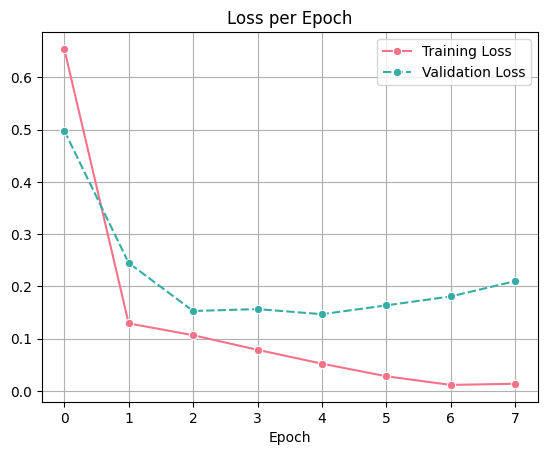

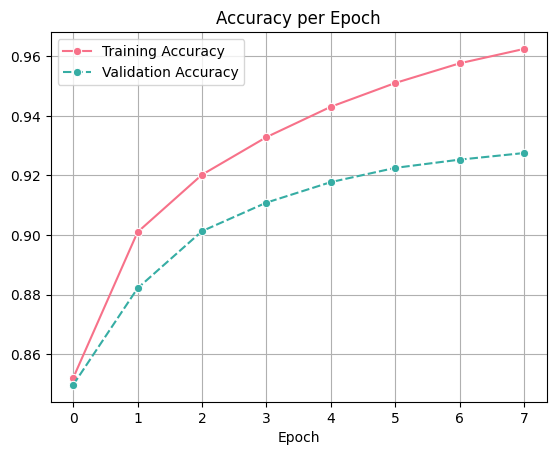

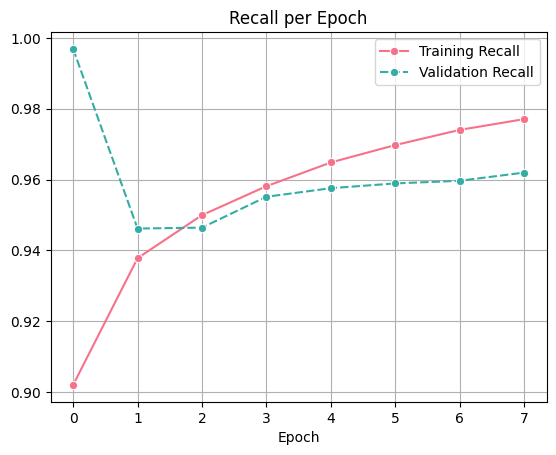

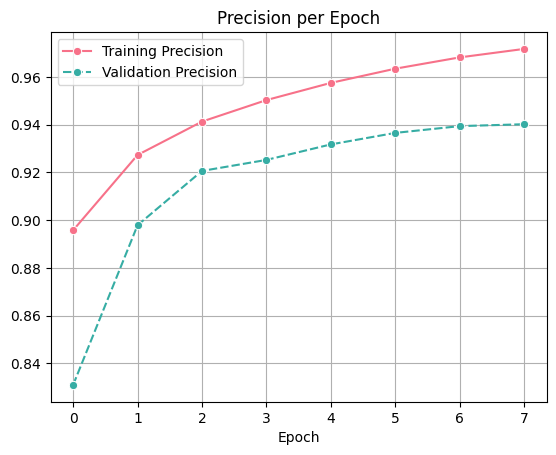

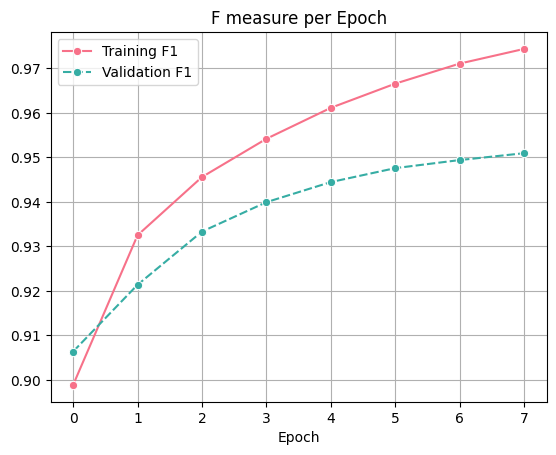

In [7]:
### IMPORTANT: If the reader is using this notebook to infer images from trained model, please do not run this cell! ###

def draw_line_chart(df, color_num=2, title="Chart", grid=True, x_label="Epoch", y_label=""):
  sns.lineplot(df, marker="o")
  plt.title(title)
  plt.xlabel(x_label)
  if y_label != "":
    plt.ylabel(y_label)

  if grid:
    plt.grid(True)

  plt.show()

def get_x_stat(num):
    return [e[num] for e in epoch_combined_stats]

results_df = pd.DataFrame({"Epoch": get_x_stat(0), "Training Loss": get_x_stat(1), "Validation Loss": get_x_stat(2), "Training Accuracy": get_x_stat(3), "Validation Accuracy": get_x_stat(4),
                           "Training Recall": get_x_stat(5), "Validation Recall": get_x_stat(6), "Training Precision": get_x_stat(7),
                           "Validation Precision": get_x_stat(8), "Training F1": get_x_stat(9), "Validation F1": get_x_stat(10)})

sns.set_palette("husl", 2)

draw_line_chart(results_df[["Training Loss", "Validation Loss"]], title="Loss per Epoch")

draw_line_chart(results_df[["Training Accuracy", "Validation Accuracy"]], title="Accuracy per Epoch")

draw_line_chart(results_df[["Training Recall", "Validation Recall"]], title="Recall per Epoch")

draw_line_chart(results_df[["Training Precision", "Validation Precision"]], title="Precision per Epoch")

draw_line_chart(results_df[["Training F1", "Validation F1"]], title="F measure per Epoch")



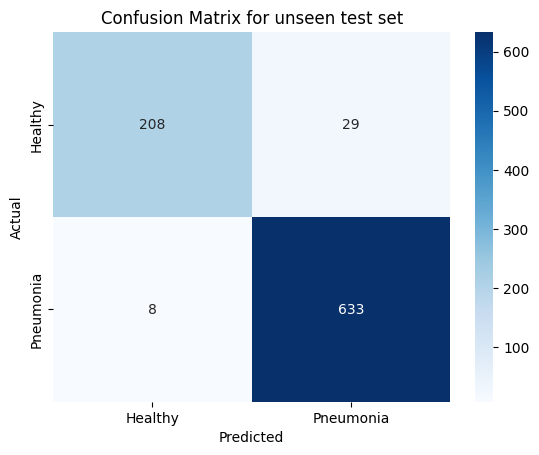

In [8]:
### IMPORTANT: If the reader is using this notebook to infer images from trained model, please do not run this cell! ###
sns.set_palette("husl", 2)

conf_labels = ["Healthy", "Pneumonia"]
sns.heatmap(conf_matrix, annot=True, xticklabels=conf_labels, yticklabels=conf_labels, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for unseen test set")
plt.show()


In [18]:
# ---- Inference ---- #

#Any inference images must be converted to the same size and images used in training: 256x256
INFER_DIR = path.join(DATASET_PATH, "testing")

start_time = time.time()
transformer_function_infer = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), transforms.Resize(IMAGE_SIZE[0])])


#Get all files from the root and sub directories:
files_to_infer = []
for root, directories, file_list in walk(INFER_DIR):
    files_to_infer.extend([path.join(root, x) for x in file_list])
    
#Shuffle the images, because why not, and use a short sample size from it for inference
random.shuffle(files_to_infer)
INFER_MAX_COUNT = 20

device = "cpu"
#output_channels for init obsolete after experimentation.
infer_model = CNN_Custom(1, 1)
infer_model.load_state_dict(torch.load("trained_model/custom_cnn_8epoch_final_state.pth", map_location="cpu"))
infer_model.eval()

with torch.no_grad():

  for current_file in files_to_infer[:INFER_MAX_COUNT]:
    current_image = pil_image.open(current_file)
    transformed = transformer_function_infer(current_image)
    
    transformed = transformed.unsqueeze(0)
    transformed = transformed.to(device)
        
    y_out = infer_model.forward(transformed)
    y_out = y_out.squeeze(1)
    prediction = torch.special.expit(y_out).detach().numpy().tolist()[0]
    if prediction > 0.5:
        pred_string = "Pneumonia"
    else:
        pred_string = "Healthy"
        
    print("For file: {} -- Prediction is: {} -- Raw score is: {}".format(current_file, pred_string, prediction))


print("Time taken to infer {} images: {}".format(INFER_MAX_COUNT, time.time() - start_time))



For file: shuffled_dataset/testing/pneumonia/person567_bacteria_2353.jpeg -- Prediction is: Pneumonia -- Raw score is: 1.0
For file: shuffled_dataset/testing/pneumonia/person620_virus_1191.jpeg -- Prediction is: Pneumonia -- Raw score is: 0.9998314380645752
For file: shuffled_dataset/testing/pneumonia/person1_virus_8.jpeg -- Prediction is: Pneumonia -- Raw score is: 1.0
For file: shuffled_dataset/testing/healthy/NORMAL2-IM-0282-0001.jpeg -- Prediction is: Healthy -- Raw score is: 0.007032100111246109
For file: shuffled_dataset/testing/pneumonia/person260_bacteria_1222.jpeg -- Prediction is: Pneumonia -- Raw score is: 0.9999997615814209
For file: shuffled_dataset/testing/pneumonia/person1465_virus_2537.jpeg -- Prediction is: Pneumonia -- Raw score is: 0.9999995231628418
For file: shuffled_dataset/testing/pneumonia/person266_bacteria_1247.jpeg -- Prediction is: Pneumonia -- Raw score is: 1.0
For file: shuffled_dataset/testing/pneumonia/person1405_bacteria_3571.jpeg -- Prediction is: Pneu

/media/U16-Data/Software/Virtual-Enviroments/Conda/Install/envs/UoL-New/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


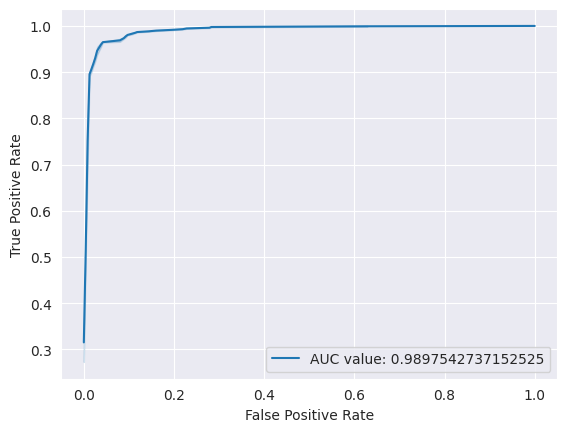

In [15]:
#ROC-AUC for unseen test data, from pretrained model
device = "cpu"
testing_predictions = []
testing_predictions_raw = []
testing_actual = []

infer_model = CNN_Custom(1, 1)
infer_model.load_state_dict(torch.load("trained_model/custom_cnn_8epoch_final_state.pth", map_location=device))
infer_model.eval()

with torch.no_grad():

  for idx, (testing_x, testing_y, img_path) in enumerate(testing_loader):
    testing_x = testing_x.to(device)
    testing_y = testing_y.to(device)

    y_out = infer_model.forward(testing_x)
    y_out = y_out.squeeze(1)
    testing_y = testing_y.float()

    prediction = torch.special.expit(y_out)
    prediction_rounded = torch.round(prediction).detach().cpu().numpy().tolist()
    prediction = prediction.detach().cpu().numpy().tolist()
    testing_predictions.extend(prediction_rounded)
    testing_predictions_raw.extend(prediction)
    testing_actual.extend(testing_y.detach().cpu().numpy().tolist())

false_positive_rate, true_positive_rate, thresholds = roc_curve(testing_actual, testing_predictions_raw)
auc_score = roc_auc_score(testing_actual, testing_predictions_raw)

sns.lineplot(x=false_positive_rate, y=true_positive_rate, legend=False)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC value: {}".format(auc_score)], loc="lower right")
plt.show()
